## Skin Tone Detection using MST Scale

Discusssion from last meeting:

![Alt text](meeting1.jpg)

<div style="background-color:black; color:white; font-family: 'Times New Roman', serif;">
    <h1>Albedo and Illumination</h1>
</div>


A simplified version that uses edge detection to approximate areas of high curvature (which indirectly relate to changes in normals) and then modulates these areas to simulate shading effects under a uniform light source. 

<div style="background-color:black; color:white; font-family: 'Times New Roman', serif;">
    <h1>Approach 1 - Estimate Shading through Edge Detection</h1>
</div>

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def estimate_shading(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect edges using Canny edge detector
    edges = cv2.Canny(gray_image, 100, 200)
    # Convert edges to a floating point type and invert such that edges are dark
    edges_f = (255 - edges).astype(np.float32) / 255.0
    # Blur the edges to simulate a smoother transition in shading
    blurred_edges = cv2.GaussianBlur(edges_f, (21, 21), sigmaX=0, sigmaY=0)
    # Apply the blurred edges as a mask to darken the original image
    # Note: This step simulates a basic shading effect and is not physically accurate
    shaded_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR) * blurred_edges[:, :, np.newaxis]
    return np.clip(shaded_image, 0, 255).astype(np.uint8)

# Loading RGB facial image
image_path = 'test.jpg'
image = cv2.imread(image_path)

# Simulate shading based on edges
shaded_image = estimate_shading(image)

# Convert images from BGR to RGB for displaying in matplotlib
#image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
shaded_image_rgb = cv2.cvtColor(shaded_image, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


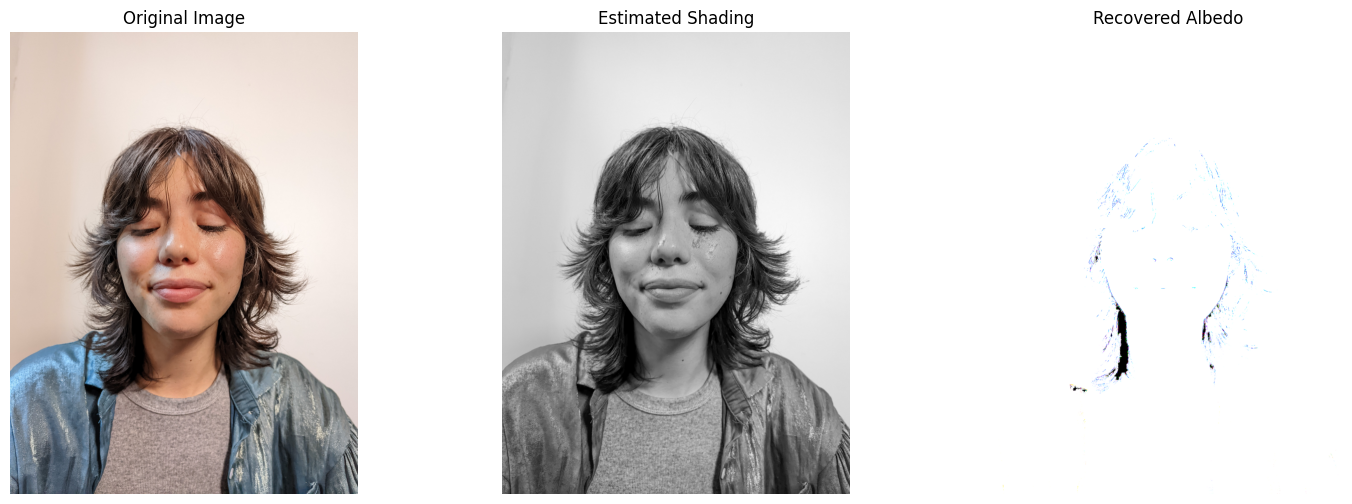

In [10]:

def recover_albedo(image, shading):
    """
    Recover the albedo by dividing the image by its shading component.
    
    :param image: Input grayscale image as a numpy array.
    :param shading: Estimated shading as a numpy array.
    :return: Recovered albedo as a numpy array.
    """
    # Avoid division by zero
    shading = np.where(shading == 0, 1, shading)
    
    # Recover albedo by dividing the image by shading
    albedo = cv2.divide(image.astype(np.float32), shading.astype(np.float32))
    
    # Normalize albedo to have a max value of 255
    albedo = cv2.normalize(albedo, None, 0, 255, cv2.NORM_MINMAX)
    
    return albedo


#grayscale image
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Estimate shading
shading = estimate_shading(image)

# Recover albedo
albedo = recover_albedo(image, shading)

# Display the results
# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(shading)
plt.title('Estimated Shading')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(albedo)
plt.title('Recovered Albedo')
plt.axis('off')

plt.show()


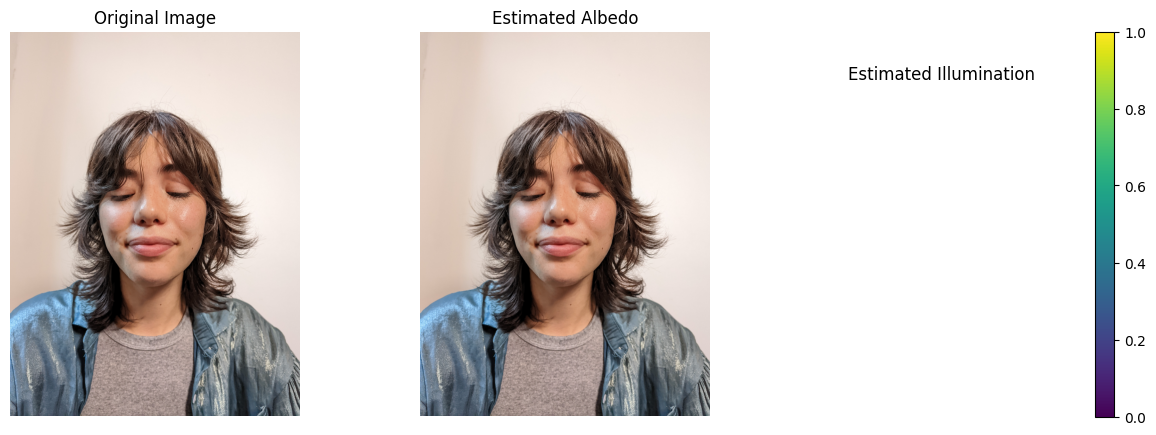

In [11]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize the image to [0, 1]
    img = img / 255.0
    return img

def estimate_albedo_and_illumination(img):
    # This is a simplified method that estimates illumination as the max value in each channel
    # and albedo as the image normalized by this estimated illumination
    illumination = np.max(img, axis=(0, 1))
    
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        albedo = img / illumination
        albedo[~np.isfinite(albedo)] = 0  # Replace inf and NaN with 0
    
    return albedo, illumination

def main(image_path):
    img = load_and_preprocess_image(image_path)
    
    albedo, illumination = estimate_albedo_and_illumination(img)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(albedo)
    plt.title('Estimated Albedo')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Estimated Illumination')
    plt.axis('off')
    plt.imshow(np.tile(illumination, (10, 10, 1)), vmin=0, vmax=1)
    plt.colorbar()
    
    plt.show()

# Replace 'path_to_your_image.jpg' with the path to the image you want to process
main('test.jpg')


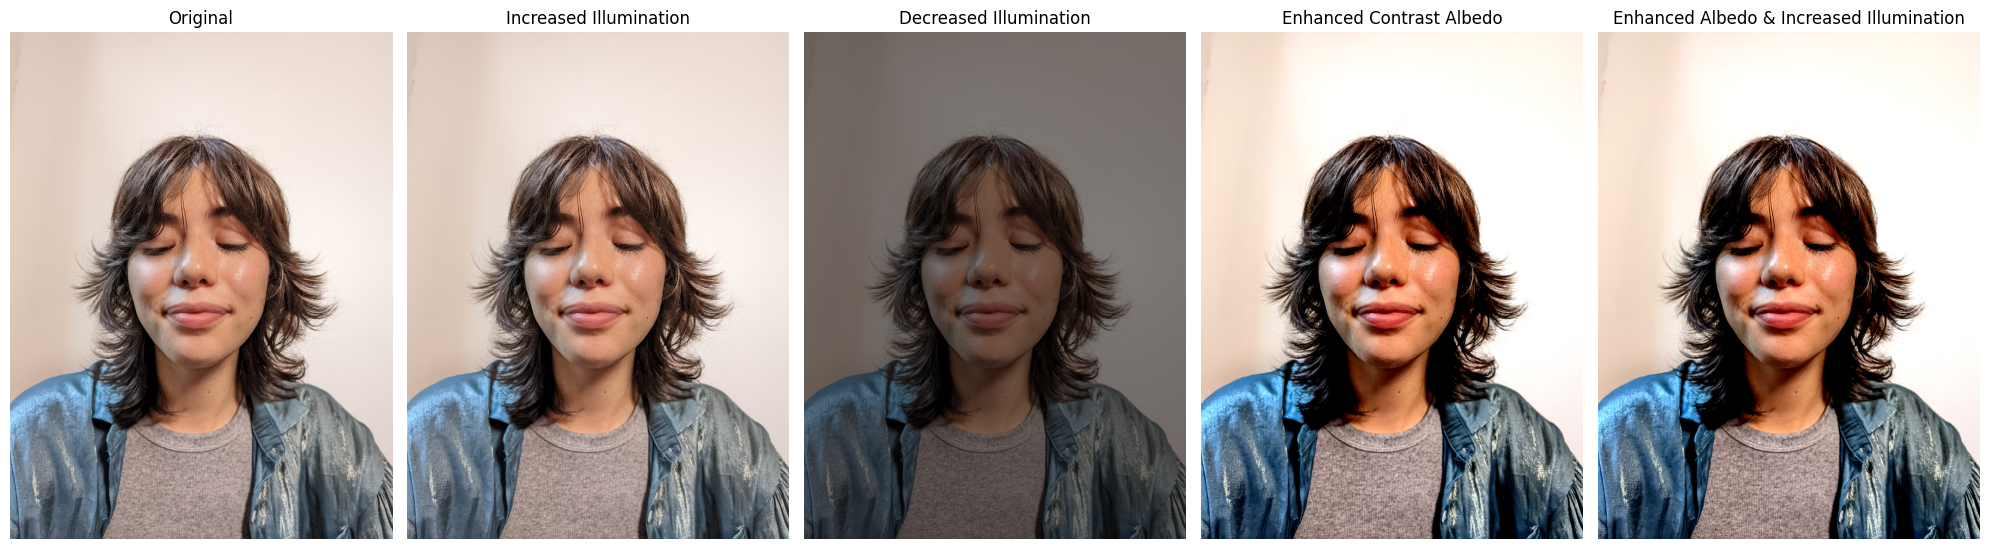

In [13]:
def estimate_albedo_and_illumination(img):
    illumination = np.max(img, axis=(0, 1))
    with np.errstate(divide='ignore', invalid='ignore'):
        albedo = img / illumination
        albedo[~np.isfinite(albedo)] = 0
    return albedo, illumination

def adjust_illumination(illumination, factor):
    # Adjust the illumination by a given factor, making sure not to exceed 1
    return np.clip(illumination * factor, 0, 1)

def adjust_albedo_contrast(albedo, factor):
    # Adjust the contrast of the albedo
    mean = np.mean(albedo, axis=(0, 1))
    return np.clip((1 + factor) * (albedo - mean) + mean, 0, 1)

def combine_albedo_illumination(albedo, illumination):
    # Combine albedo and illumination
    return np.clip(albedo * illumination, 0, 1)

def generate_combinations(image_path):
    img = load_and_preprocess_image(image_path)
    albedo, illumination = estimate_albedo_and_illumination(img)
    
    # Generating different combinations
    combinations = [
        ('Original', img),
        ('Increased Illumination', combine_albedo_illumination(albedo, adjust_illumination(illumination, 50))),
        ('Decreased Illumination', combine_albedo_illumination(albedo, adjust_illumination(illumination, 0.5))),
        ('Enhanced Contrast Albedo', combine_albedo_illumination(adjust_albedo_contrast(albedo, 0.5), illumination)),
        ('Enhanced Albedo & Increased Illumination', combine_albedo_illumination(adjust_albedo_contrast(albedo, 0.5), adjust_illumination(illumination, 1.5)))
    ]
    
    plt.figure(figsize=(20, 10))
    for i, (title, combination) in enumerate(combinations, 1):
        plt.subplot(1, len(combinations), i)
        plt.imshow(combination)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Replace 'path_to_your_image.jpg' with the path to the image you want to process
generate_combinations('test.jpg')
